# **Non-Textual Data Case Study: Using Word2vec for Online Product Recommender System**

Can you guess the fundamental property of a natural language that word2vec exploits to create vector representations of text?

It is the **sequential nature of the text**. Every sentence or phrase has a sequence of words. In the absence of this sequence, we would have a hard time understanding the text. Just try to interpret the sentence below:

    these most been languages deciphered written of have already

There is no sequence in this sentence. It becomes difficult for us to grasp it and that’s why the sequence of words is so important in any natural language. This very property can be applied to data other than text that has a sequential nature as well.

One such data is the **purchases made by the consumers on E-commerce websites**. Most of the time there is a pattern in the buying behavior of the consumers. For example, a person involved in sports-related activities might have an online buying pattern similar to this:

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/07/img_7.png"></center>

If we can represent each of these products by a vector, then we can easily find similar products. So, if a user is checking out a product online, then we can easily recommend him/her similar products by using the vector **similarity score** between the products.

But how do we get a vector representation of these products? Can we use the word2vec model to get these vectors?

We surely can! Just imagine **the buying history of a consumer as a sentence** and **the products as its words**:

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/07/img_9.png"></center>

Now, let’s set up and understand our problem statement:

**We are asked to create a system that automatically recommends a certain number of products to the consumers on an E-commerce website based on the past purchase behavior of the consumers.**

## Import Libraries and Model

Let’s fire up our Notebook and quickly import the required libraries.

In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download pre-trained model
# you can replace the id with id of file you want to access
model_id = "1-rFzYA2oNPm2F680L4FsjnkIpDzCDlwK"
downloaded = drive.CreateFile({'id':model_id})
downloaded.GetContentFile('recommender.model')

In [0]:
# data analysis
import pandas as pd
import numpy as np

# progress bar
from tqdm import tqdm

# modeling
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

## Explore the Data
We are going to use an Online Retail Dataset that you can download from this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/).

### Import Data

In [0]:
url = 'https://github.com/tomytjandra/word2vec-embeddings/blob/master/dataset/Online%20Retail.xlsx?raw=true'
retail = pd.read_excel(url)
retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


### Column Description

In [0]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


The dataset contains 541909 transactions. That is a pretty good number for us to build our model.

Here is the description of the fields in this dataset:

1. `InvoiceNo`: Invoice number. a unique number assigned to each transaction
2. **`StockCode`: Product/item code. a unique number assigned to each distinct product**
3. **`Description`: Product name**
4. `Quantity`: The quantities of each product per transaction
5. `InvoiceDate`: Invoice Date and time. The day and time when each transaction was generated
6. `UnitPrice`: Price of each unit product
7. **`CustomerID`: Customer number. a unique number assigned to each customer**
8. `Country`: The country where each transaction was generated

### Check Date
Check whether `InvoiceDate` has been sorted increasingly or not.

In [0]:
retail["InvoiceDate"].is_monotonic_increasing

True

## Prepare the Data

### Missing Values
Check for missing values

In [0]:
retail.isnull().sum()

InvoiceNo      0     
StockCode      0     
Description    1454  
Quantity       0     
InvoiceDate    0     
UnitPrice      0     
CustomerID     135080
Country        0     
dtype: int64

Since we have sufficient data, we will **drop all the rows** with missing values.

In [0]:
retail.dropna(inplace=True)

### Data Type Conversion

In [0]:
retail.dtypes

InvoiceNo      object        
StockCode      object        
Description    object        
Quantity       int64         
InvoiceDate    datetime64[ns]
UnitPrice      float64       
CustomerID     float64       
Country        object        
dtype: object

In [0]:
retail["CustomerID"] = retail["CustomerID"].astype(int)
retail[["InvoiceNo", "StockCode", "Description", "CustomerID"]] = retail[["InvoiceNo", "StockCode", "Description", "CustomerID"]].astype(str)
retail["Country"] = retail["Country"].astype("category")

In [0]:
retail.dtypes

InvoiceNo      object        
StockCode      object        
Description    object        
Quantity       int64         
InvoiceDate    datetime64[ns]
UnitPrice      float64       
CustomerID     object        
Country        category      
dtype: object

### Remove Leading and Trailing Whitespace
Some of the product description have leading and trailing whitespace as shown below:

In [0]:
retail["Description"].values

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'CHILDRENS CUTLERY DOLLY GIRL ', 'CHILDRENS CUTLERY CIRCUS PARADE',
       'BAKING SET 9 PIECE RETROSPOT '], dtype=object)

Let's remove it:

In [0]:
retail["Description"] = retail["Description"].str.strip()
retail["Description"].values

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'CHILDRENS CUTLERY DOLLY GIRL', 'CHILDRENS CUTLERY CIRCUS PARADE',
       'BAKING SET 9 PIECE RETROSPOT'], dtype=object)

### Splitting Data

There are 4372 unique customers in our dataset. For each of these customers, we will extract their buying history. In other words, we can have 4372 sequences of purchases.

In [0]:
customers = retail["CustomerID"].unique().tolist()
len(customers)

4372


It is a good practice to set aside a small part of the dataset for validation purposes. Therefore, we will use the data of **95% of the customers** to create word2vec embeddings. Let’s split the data.

In [0]:
customers_train, customers_val = train_test_split(customers, train_size = 0.95, shuffle = True, random_state = 123)

retail_train = retail[retail["CustomerID"].isin(customers_train)]
retail_val = retail[retail["CustomerID"].isin(customers_val)]

print("No. of Customers in Training Data:", len(customers_train))
print("Dim. of Purchases in Training Data:", retail_train.shape)
print("No. of Customers in Validation Data:", len(customers_val))
print("Dim. of Purchases in Validation Data:", retail_val.shape)

No. of Customers in Training Data: 4153
Dim. of Purchases in Training Data: (390857, 8)
No. of Customers in Validation Data: 219
Dim. of Purchases in Validation Data: (15972, 8)


### List of Purchases
We will create sequences of purchases made by the customers in the dataset for both the train and validation set.

In [0]:
def purchasesList(df):
  purchases_list = []

  customers_list = df['CustomerID'].unique()
  for customer in tqdm(customers_list):
    customer_purchases_list = df[df["CustomerID"] == customer]["StockCode"].tolist()
    purchases_list.append(customer_purchases_list)
  
  return purchases_list

In [0]:
# list to capture purchase history of the customers
purchases_train = purchasesList(retail_train)
purchases_val = purchasesList(retail_val)

100%|██████████| 219/219 [00:00<00:00, 472.04it/s]


## Word2Vec Embeddings
Let's prepare a callback to print loss after each epoch

In [0]:
from gensim.models.callbacks import CallbackAny2Vec

class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 1:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

Step to train the model:
1. Initialize the Word2Vec settings
2. Build vocabulary from a sequence of sentences
3. Update the model’s neural weights from a sequence of sentences

In [0]:
callback = Callback()

model = Word2Vec(
    size = 100, # dimensionality of the word vectors
    window = 10, # max distance between context and target word
    min_count = 5, # frequency cut-off
    sg = 1, # using skip-gram
    hs = 0, # no hierarchical softmax (default)
    negative = 15, # negative sampling data
    alpha = 0.005, # learning rate
    seed = 123, # reproducibility
    workers = 1)

model.build_vocab(purchases_train)

model.train(purchases_train,
            total_examples = model.corpus_count, # count of sentences 
            epochs = 10, # number of iterations over the corpus
            compute_loss = True, # to track model loss
            callbacks = [callback]) 

Loss after epoch 1: 13739012.0
Loss after epoch 2: 9969096.0
Loss after epoch 3: 9610266.0
Loss after epoch 4: 11308194.0
Loss after epoch 5: 11223612.0
Loss after epoch 6: 11192972.0
Loss after epoch 7: 963048.0
Loss after epoch 8: 878904.0
Loss after epoch 9: 845232.0
Loss after epoch 10: 814056.0


(3869966, 3908570)

Let’s check out the summary of our `model`:

In [0]:
model = Word2Vec.load("recommender.model")
print(model)

Word2Vec(vocab=3196, size=100, alpha=0.005)


Our model has a vocabulary of **3196 unique products** and their **vectors of size 100** each. Next, we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

In [0]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3196, 100)

## Visualize Word2Vec
It is always quite helpful to visualize the embeddings that you have created. Over here, we have 100-dimensional embeddings. We can’t even visualize 4 dimensions let alone 100. What in the world can we do?

We are going to reduce the dimensions of the product embeddings from 100 to 2 by using various dimensionality reduction algorithm:
1. Principal Component Analysis (PCA)
2. t-Distributed Stochastic Neighbor Embedding (t-SNE)
3. Uniform Manifold Approximation and Projection (UMAP)

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

X_pca = PCA(n_components = 2).fit_transform(X)
X_tsne = TSNE(n_components = 2, random_state = 123).fit_transform(X)
X_umap = UMAP(n_components = 2, random_state = 123).fit_transform(X)

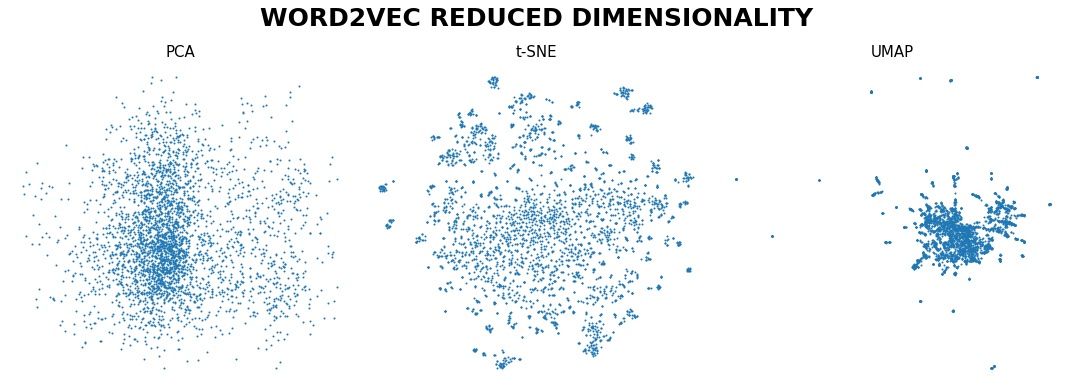

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.patch.set_facecolor("white")

for ax, X_reduced, title in zip(axes, [X_pca, X_tsne, X_umap], ["PCA", "t-SNE", "UMAP"]):
  ax.scatter(X_reduced[:,0], X_reduced[:,1], s = 1)
  ax.axis("off")
  ax.set_title(title, fontsize=15)

plt.tight_layout()
fig.suptitle("WORD2VEC REDUCED DIMENSIONALITY", size = 25, y = 1.075, fontweight = "bold")
plt.show()

## Start Recommending Products
Congratulations! We are finally ready with the word2vec embeddings for every product in our online retail dataset. Now, our next step is to suggest similar products for a certain product or a product’s vector.

Let’s first create a dictionary to easily map a product’s `Description` to its `StockCode` and vice versa.

In [0]:
products = retail[["StockCode", "Description"]]

# example of duplicates
products[products["StockCode"] == "22632"].drop_duplicates()

,StockCode,Description
8,22632,HAND WARMER RED POLKA DOT
257,22632,HAND WARMER RED RETROSPOT


In [0]:
# remove duplicates
products.drop_duplicates(subset="StockCode", keep="last", inplace=True)

# create a dictionary for mapping
code_to_name = pd.Series(products["Description"].values, index = products["StockCode"]).to_dict()
dict(list(code_to_name.items())[:20])

{'16161M': 'WRAP  PINK FLOCK',
 '20878': 'SET/9 CHRISTMAS T-LIGHTS SCENTED',
 '20957': 'PORCELAIN HANGING BELL SMALL',
 '21268': 'VINTAGE BLUE TINSEL REEL',
 '21486': 'PINK HEART DOTS HOT WATER BOTTLE',
 '21488': 'RED WHITE SCARF  HOT WATER BOTTLE',
 '21895': "POTTING SHED SOW 'N' GROW SET",
 '22275': 'WEEKEND BAG VINTAGE ROSE PAISLEY',
 '35271S': 'GOLD PRINT PAPER BAG',
 '37461': 'FUNKY MONKEY MUG',
 '47503J': 'SET/3 FLORAL GARDEN TOOLS IN BAG',
 '47579': 'TEA TIME BREAKFAST BASKET',
 '82615': 'PINK MARSHMALLOW SCARF KNITTING KIT',
 '84614A': 'PINK BAROQUE FLOCK CANDLE HOLDER',
 '84773': 'RED ROSE AND LACE C/COVER',
 '84854': 'GIRLY PINK TOOL SET',
 '84963A': 'PINK PAINTED KASHMIRI CHAIR',
 '90128B': 'BLUE LEAVES AND BEADS PHONE CHARM',
 '90152B': 'BLUE/GREEN SHELL NECKLACE W PENDANT',
 '90167': 'BEADED LOVE HEART JEWELLERY SET'}

### Case 1: Recommendation based on last bought product
I have defined the function below. It will take a product's `StockCode` as input and return top `n` similar products.

In [0]:
def similarProductsByVector(vec, n = 10):
    
    # extract most similar products for the input vector
    similar_products = model.wv.similar_by_vector(vec, topn = n)
    
    # extract name and similarity score of the similar products
    product_list = []
    for prod, sim in similar_products:
        product_list.append((code_to_name[prod], sim))

    return product_list

Let's try out our function by passing the `StockCode` "90019A" ('SILVER M.O.P ORBIT BRACELET')

In [0]:
code_to_name["90019A"]

'SILVER M.O.P ORBIT BRACELET'

In [0]:
similarProductsByVector(model["90019A"])

[('SILVER M.O.P ORBIT BRACELET', 1.0),
 ('PINK ROSEBUD PEARL BRACELET', 0.988038182258606),
 ('SILVER ROCCOCO CHANDELIER', 0.986005425453186),
 ('MIDNIGHT BLUE GLASS/SILVER BRACELET', 0.9858831167221069),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.9858506321907043),
 ('SOFT PINK ROSE TOWEL', 0.983485221862793),
 ('WHITE VINT ART DECO CRYSTAL NECKLAC', 0.9819661378860474),
 ('MIRROR MOSAIC CANDLE PLATE', 0.9817532300949097),
 ('WOVEN BUBBLE GUM CUSHION COVER', 0.981330156326294),
 ('CRYSTAL PAIR HEART HAIR SLIDES', 0.9808048009872437)]

Identify **last bought products** for each `CustomerID` and recommend them 3 other similar products.


In [0]:
last_bought = retail_val.drop_duplicates(subset="CustomerID", keep="last")
last_bought.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6352,536884,48185,DOORMAT FAIRY CAKE,1,2010-12-03 11:42:00,7.95,14589,United Kingdom
19025,537827,22145,CHRISTMAS CRAFT HEART STOCKING,30,2010-12-08 14:43:00,2.10,15332,Lithuania
21696,538108,20676,RED RETROSPOT BOWL,8,2010-12-09 15:23:00,1.25,17456,United Kingdom
23212,538184,22904,CALENDAR PAPER CUT DESIGN,6,2010-12-10 10:21:00,2.95,17880,United Kingdom
25079,538352,51008,AFGHAN SLIPPER SOCK PAIR,40,2010-12-10 15:21:00,3.45,16565,United Kingdom


In [0]:
recommendation_df = []
for idx, s in last_bought.iterrows():  
  temp_dict = {}
  temp_dict["CustomerID"] = s["CustomerID"]
  temp_dict["Last Bought Product"] = code_to_name[s["StockCode"]]
  try:
    temp_dict["Recommended Products"] = np.transpose(similarProductsByVector(model[s["StockCode"]], n=4))[0][1:]
  except KeyError:
    continue
  recommendation_df.append(temp_dict)

pd.DataFrame(recommendation_df).sample(5, random_state = 123)

,CustomerID,Last Bought Product,Recommended Products
204,14282,LUNCH BAG PAISLEY PARK,"[LUNCH BAG RED VINTAGE DOILY, JUMBO BAG PAISLEY PARK, VINTAGE DOILY JUMBO BAG RED]"
203,17290,DOORMAT SPOTTY HOME SWEET HOME,"[DOORMAT FANCY FONT HOME SWEET HOME, DOORMAT NEW ENGLAND, DOORMAT AIRMAIL]"
31,13723,PICNIC BASKET WICKER SMALL,"[PICNIC BASKET WICKER LARGE, CHERRY BLOSSOM DECORATIVE FLASK, ENCHANTED BIRD PLANT CAGE]"
186,16496,YOU'RE CONFUSING ME METAL SIGN,"[METAL SIGN NEIGHBOURHOOD WITCH, CHOCOLATE THIS WAY METAL SIGN, COOK WITH WINE METAL SIGN]"
169,15838,HAND WARMER OWL DESIGN,"[HAND WARMER SCOTTY DOG DESIGN, HAND WARMER BIRD DESIGN, HAND WARMER RED LOVE HEART]"


Cool! The results are pretty relevant and match well with the input product. However, this output is based on the vector of a single product only. What if we want recommend a user products based on the **multiple purchases** he or she has made in the past?

### Case 2: Recommendation based on multiple purchases
One simple solution is to take **average of all the vectors of the products** he has bought so far and use this resultant vector to find similar products. For that we will use the function below that takes in a list of product ID's and gives out a 100 dimensional vector which is mean of vectors of the products in the input list.

In [0]:
def aggregateVectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

If you can recall, we have already created a separate list of purchase sequences for validation purpose. Now let's make use of that.

In [0]:
len(purchases_val[-1])

18

The length of the first list of products purchased by a user is 240. We will pass this products' sequence of the validation set to the function aggregate_vectors.


In [0]:
aggregateVectors(purchases_val[-1]).shape

(100,)

Well, the function has returned an array of 100 dimensions. It means the function is working fine. Now we can use this result to get the most similar products. Let's do it.

In [0]:
similarProductsByVector(aggregateVectors(purchases_val[-1]))

[('METAL SIGN TAKE IT OR LEAVE IT', 0.9587694406509399),
 ('BEWARE OF THE CAT METAL SIGN', 0.9575548768043518),
 ('CHOCOLATE THIS WAY METAL SIGN', 0.952998161315918),
 ('AREA PATROLLED METAL SIGN', 0.9523403644561768),
 ('OPEN CLOSED METAL SIGN', 0.9495117664337158),
 ('HOT BATHS METAL SIGN', 0.9472224712371826),
 ('N0 SINGING METAL SIGN', 0.9446829557418823),
 ("YOU'RE CONFUSING ME METAL SIGN", 0.9446626901626587),
 ('METAL SIGN NEIGHBOURHOOD WITCH', 0.9415547251701355),
 ("I'M ON HOLIDAY METAL SIGN", 0.9393553137779236)]

As it turns out, our system has recommended products based on the entire purchase history of a user. Feel free to play this code, try to get product recommendation for more sequences from the validation set.